**Libraries/Imports**

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier


**Data Preprocessing**

In [53]:
# Reading in raw Pokemon Database.csv
raw = pd.read_csv('Pokemon Database.csv')

# Cleaning string values
for index, pokemon in raw.iterrows():
    for column in raw.columns:
        if isinstance(pokemon[column], str):
            raw.at[index, column] = pokemon[column][1:-1]

# Converting Alternate Form Name to Correct Names
raw["Alternate Form Name"] = raw["Alternate Form Name"].replace({
    "Hisui": "Hisuian",
    "Alola": "Alolan",
    "Galar": "Galarian"
})    

# Updating Pokemon Names and Handling Missing Values
for index, pokemon in raw.iterrows():
    if pd.isna(pokemon['Legendary Type']):
        raw.at[index, "Legendary Type"] = "Regular"
    if pd.isna(pokemon["Secondary Type"]):
        raw.at[index, "Secondary Type"] = pokemon["Primary Type"]     
    alternate_form = pokemon['Alternate Form Name']
    if not pd.isna(alternate_form) and isinstance(alternate_form, str):
        if alternate_form in ["Mega X", "Mega Y"]:
            raw.at[index, "Pokemon Name"] = f"Mega {raw.at[index, 'Pokemon Name']} {alternate_form[-1]}"
        elif pokemon["Pokemon Name"] in ["Unown", "Hoopa"]:
            raw.at[index, "Pokemon Name"] = f"{raw.at[index, 'Pokemon Name']} {alternate_form}"
        else:
            raw.at[index, "Pokemon Name"] = f"{alternate_form} {raw.at[index, 'Pokemon Name']}"

# Selecting Relevant Columns
relevant = raw[['Pokemon Id', 'Pokedex Number', 'Pokemon Name',
       'Alternate Form Name', 'Original Pokemon ID', 'Legendary Type',
       'Pokemon Height', 'Pokemon Weight', 'Primary Type', 'Secondary Type', 
       'Male Ratio', 'Female Ratio', 'Base Happiness', 'Health Stat', 'Attack Stat',
       'Defense Stat', 'Special Attack Stat', 'Special Defense Stat',
       'Speed Stat', 'Base Stat Total', 'Health EV', 'Attack EV', 'Defense EV',
       'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total',
       'Catch Rate', 'Experience Growth', 'Experience Growth Total', 'Egg Cycle Count']]

# Remove Gigantamax Forms
relevant = relevant.loc[relevant['Alternate Form Name'] != 'Gigantamax']
relevant = relevant.reset_index()

# Define Features for Transformation
features = ['Legendary Type', 'Pokemon Height', 'Pokemon Weight', 'Primary Type', 'Secondary Type',
            'Male Ratio', 'Female Ratio', 'Base Happiness', 'Health Stat', 'Attack Stat', 'Defense Stat', 
            'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total', 'Health EV', 
            'Attack EV', 'Defense EV', 'Special Attack EV', 'Special Defense EV', 'Speed EV', 
            'EV Yield Total', 'Catch Rate', 'Experience Growth', 'Experience Growth Total', 'Egg Cycle Count'] 

# Define Numerical Features
numerical_features = [col for col in features if col not in ['Legendary Type', 'Experience Growth', 'Primary Type', 'Secondary Type']]

# Apply Label Encoding to Typings (For Classification)
label_encoder_primary = LabelEncoder()
label_encoder_secondary = LabelEncoder()

relevant['Primary Typing Label'] = label_encoder_primary.fit_transform(relevant['Primary Type'])
relevant['Secondary Typing Label'] = label_encoder_secondary.fit_transform(relevant['Secondary Type'])

# Define One-Hot Encoding for Categorical Features, Scaling Values
categorical_features = ['Legendary Type', 'Experience Growth']
transformer = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),  
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  
])

# Apply Transformations
transformed = transformer.fit_transform(relevant[features])
encoded_feature_names = transformer.get_feature_names_out()

# Convert to DataFrame
processed = pd.DataFrame(transformed, columns=encoded_feature_names)

# Add Primary & Secondary Typing Labels
processed['Primary Typing Label'] = relevant['Primary Typing Label']
processed['Secondary Typing Label'] = relevant['Secondary Typing Label']

# Save Processed Data
print(processed.shape)
processed.to_csv('processed_data.csv', index=False)

(1350, 34)


**Splitting Test and Train Datasets**

In [40]:
# Defining Features and Labels Matricies
X = processed.drop(columns=['Primary Typing Label', 'Secondary Typing Label'])
y_primary = processed[['Primary Typing Label']]
y_secondary = processed[['Secondary Typing Label']]

y_svm = y_primary.values.ravel()

# Split into training and test data
X_train, X_test, y_primary_train, y_primary_test, y_secondary_train, y_secondary_test = train_test_split(X, y_primary, y_secondary, test_size=0.2, random_state=42)

**Random Guess**

In [41]:
# Declari Classifier and Train
random_guess = DummyClassifier(strategy='uniform', random_state=42)
random_guess.fit(X_train, y_primary_train)

# Predict
y_pred = random_guess.predict(X_test)

# Accuracy Report
print(classification_report(y_primary_test, y_pred))

              precision    recall  f1-score   support

           0       0.04      0.04      0.04        26
           1       0.13      0.12      0.13        16
           2       0.00      0.00      0.00         9
           3       0.14      0.15      0.15        13
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         0
           8       0.06      0.14      0.09         7
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         9
          12       0.11      0.03      0.05        32
          13       0.00      0.00      0.00        11
          14       0.07      0.05      0.06        22
          15       0.12      0.08      0.10        24
          16       0.06      0.09      0.07        11
          17       0.10    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

**Probabilistic Guess**

In [43]:
# Declari Classifier and Train
prob_guess = DummyClassifier(strategy='stratified', random_state=42)
prob_guess.fit(X_train, y_primary_train)

# Predict
y_pred = prob_guess.predict(X_test)

# Accuracy Report
print(classification_report(y_primary_test, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.08      0.08        26
           1       0.08      0.06      0.07        16
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        12
           5       0.11      0.11      0.11         9
           6       0.07      0.08      0.07        13
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         7
           9       0.11      0.18      0.14        17
          10       0.00      0.00      0.00         8
          11       0.14      0.11      0.12         9
          12       0.04      0.03      0.03        32
          13       0.10      0.09      0.10        11
          14       0.08      0.09      0.09        22
          15       0.00      0.00      0.00        24
          16       0.09      0.09      0.09        11
          17       0.12    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

SVM Model (Primary Only)

In [44]:
# Declare Classifier and Train
svm_classifier = SVC(kernel='rbf', decision_function_shape='ovr')  # 'ovo' also works
svm_classifier.fit(X_train, y_primary_train)

# Predict
y_pred = svm_classifier.predict(X_test)

# Classification Report
print(classification_report(y_primary_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        26
           1       0.00      0.00      0.00        16
           2       0.36      0.56      0.43         9
           3       0.36      0.31      0.33        13
           4       0.89      0.67      0.76        12
           5       0.25      0.22      0.24         9
           6       0.43      0.23      0.30        13
           8       0.14      0.14      0.14         7
           9       0.21      0.35      0.27        17
          10       0.10      0.12      0.11         8
          11       0.00      0.00      0.00         9
          12       0.37      0.91      0.53        32
          13       0.00      0.00      0.00        11
          14       0.59      0.45      0.51        22
          15       0.88      0.29      0.44        24
          16       0.60      0.55      0.57        11
          17       0.23      0.32      0.27        31

    accuracy              

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

SVM Model (with PCA)

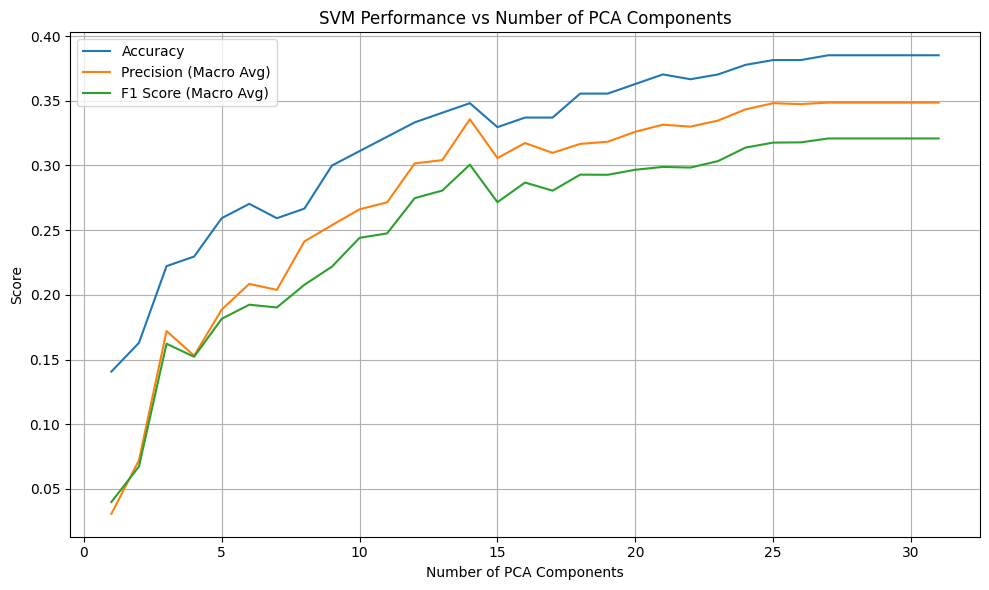

In [45]:
# Lists to store metrics
accuracies = []
precisions = []
f1_scores = []
components_range = range(1, 32)

for i in components_range:
    # Apply PCA with i components
    pca = PCA(n_components=i)
    principal_components = pca.fit_transform(X)
    pca_processed = pd.DataFrame(data=principal_components)

    # Split PCA data into train and test
    pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
        pca_processed, y_primary.values.ravel(), test_size=0.2, random_state=42
    )

    # Train the classifier
    svm_classifier = SVC(kernel='rbf', decision_function_shape='ovr')
    svm_classifier.fit(pca_X_train, pca_y_train)

    # Predict
    pca_y_pred = svm_classifier.predict(pca_X_test)

    # Store evaluation metrics
    accuracies.append(accuracy_score(pca_y_test, pca_y_pred))
    precisions.append(precision_score(pca_y_test, pca_y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(pca_y_test, pca_y_pred, average='macro', zero_division=0))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(components_range, accuracies, label='Accuracy')
plt.plot(components_range, precisions, label='Precision (Macro Avg)')
plt.plot(components_range, f1_scores, label='F1 Score (Macro Avg)')
plt.xlabel('Number of PCA Components')
plt.ylabel('Score')
plt.title('SVM Performance vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SVM (PCA + Grid Search)

In [50]:
# Define pipeline
pipeline = Pipeline([
    ('pca', PCA()),
    ('svc', SVC(decision_function_shape='ovr'))
])

# Define hyperparameter grid
param_grid = {
    'pca__n_components': range(1, 32),
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_primary_train)

# Predict on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_primary_test, y_pred)
precision = precision_score(y_primary_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_primary_test, y_pred, average='macro', zero_division=0)

print("Best Parameters:", grid_search.best_params_)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test F1 Score (macro): {f1:.4f}")

Fitting 5 folds for each of 496 candidates, totalling 2480 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

Best Parameters: {'pca__n_components': 26, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Test Accuracy: 0.4148
Test Precision (macro): 0.3724
Test F1 Score (macro): 0.3557


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**SVM Model (Primary and Secondary Type)**

Print weights


In [56]:
# Declare Classifier and Train
svm_primary = SVC(kernel='rbf', decision_function_shape='ovr')  
svm_secondary = SVC(kernel='rbf', decision_function_shape='ovr')  

# Train the primary type model
svm_primary.fit(X_train, y_primary_train)

# Train the secondary type model
svm_secondary.fit(X_train, y_secondary_train)

y_primary_predict = svm_primary.predict(X_test)
y_secondary_predict = svm_secondary.predict(X_test)

print("Primary Type Model Performance:")
print(classification_report(y_primary_test, y_primary_predict))

print("\nSecondary Type Model Performance:")
print(classification_report(y_secondary_predict, y_secondary_predict))

# Now evaluate if at least one model gets the type right
correct_count = 0
total_count = len(y_primary_test)

for i in range(total_count):
    true_types = {
        y_primary_test.iloc[i, 0],
        y_secondary_test.iloc[i, 0]
    }

    pred_types = {y_primary_predict[i], y_secondary_predict[i]}
    if len(true_types.intersection(pred_types)) > 0:
        correct_count += 1

combined_accuracy = correct_count / total_count
print(f"\nCombined Model Accuracy (correct if either prediction matches any actual type): {combined_accuracy:.4f}")

Primary Type Model Performance:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        26
           1       0.00      0.00      0.00        16
           2       0.36      0.56      0.43         9
           3       0.36      0.31      0.33        13
           4       0.89      0.67      0.76        12
           5       0.25      0.22      0.24         9
           6       0.43      0.23      0.30        13
           8       0.14      0.14      0.14         7
           9       0.21      0.35      0.27        17
          10       0.10      0.12      0.11         8
          11       0.00      0.00      0.00         9
          12       0.37      0.91      0.53        32
          13       0.00      0.00      0.00        11
          14       0.59      0.45      0.51        22
          15       0.88      0.29      0.44        24
          16       0.60      0.55      0.57        11
          17       0.23      0.32      0.27      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/

In [57]:
X_train, X_test, y_primary_train, y_primary_test, y_secondary_train, y_secondary_test = train_test_split(X, y_primary, y_secondary, test_size=0.2, random_state=42)

# Train using primary label
clf = DecisionTreeClassifier(random_state=42)  
clf.fit(X_train, y_primary_train)

y_pred = clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_primary_test, y_pred))

# Classification Report
print("Classification Report (PRIMARY ONLY):")
print(classification_report(y_primary_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_primary_test, y_pred))

correct_count = 0
for i in range(len(y_pred)):
    pred_code = y_pred[i]
    primary_code = y_primary_test.iloc[i]
    secondary_code = y_secondary_test.iloc[i]
    
    # Decode the predicted integer into a string type (using the primary encoder)
    pred_str = label_encoder_primary.inverse_transform([pred_code])[0]
    
    # Decode the true primary code into a string (also primary encoder)
    true_primary_str = label_encoder_primary.inverse_transform([primary_code])[0]
    
    # Decode the true secondary code into a string (secondary encoder!)
    true_secondary_str = label_encoder_secondary.inverse_transform([secondary_code])[0]
    
    print(f"Row {i}")
    print("  Prediction code :", pred_code, "->", pred_str)
    print("  True primary code :", primary_code, "->", true_primary_str)
    print("  True secondary code :", secondary_code, "->", true_secondary_str)
    
    # Compare as strings
    if pred_str == true_primary_str or pred_str == true_secondary_str:
        print("  => MATCH!")
        correct_count += 1
    else:
        print("  => NO MATCH")
    print()

custom_accuracy = correct_count / len(y_pred)
print("Custom Accuracy (either label counts):", custom_accuracy)

Accuracy: 0.4222222222222222
Classification Report (PRIMARY ONLY):
              precision    recall  f1-score   support

           0       0.42      0.42      0.42        26
           1       0.00      0.00      0.00        16
           2       0.62      0.56      0.59         9
           3       0.19      0.23      0.21        13
           4       0.67      0.67      0.67        12
           5       0.36      0.44      0.40         9
           6       0.42      0.62      0.50        13
           7       0.00      0.00      0.00         0
           8       0.42      0.71      0.53         7
           9       0.41      0.65      0.50        17
          10       0.30      0.38      0.33         8
          11       0.25      0.22      0.24         9
          12       0.49      0.53      0.51        32
          13       0.12      0.09      0.11        11
          14       0.67      0.45      0.54        22
          15       0.73      0.46      0.56        24
          16  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

MLP SCIKIT LEARN Model


In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

mlp_primary = MLPClassifier(hidden_layer_sizes=(100,), 
                           activation='relu',
                           solver='adam',
                           max_iter=300,
                           random_state=42)

mlp_secondary = MLPClassifier(hidden_layer_sizes=(100,), 
                             activation='relu',
                             solver='adam',
                             max_iter=300,
                             random_state=42)

y_primary = processed['Primary Typing Label']
X_train, X_test, y_train_primary, y_primary_test = train_test_split(
    X, y_primary, test_size=0.2, random_state=42)

y_secondary = processed['Secondary Typing Label']
_, _, y_train_secondary, y_secondary_test = train_test_split(
    X, y_secondary, test_size=0.2, random_state=42)

# Train the primary type model
mlp_primary.fit(X_train, y_train_primary)

# Train the secondary type model
mlp_secondary.fit(X_train, y_train_secondary)

y_primary_predict = mlp_primary.predict(X_test)
y_secondary_predict = mlp_secondary.predict(X_test)

print("Primary Type Model Performance:")
print(classification_report(y_primary_test, y_primary_predict))

print("\nSecondary Type Model Performance:")
print(classification_report(y_secondary_test, y_secondary_predict))

# Now evaluate if at least one model gets the type right
correct_count = 0
total_count = len(y_primary_test)

for i in range(total_count):
    true_types = {
        y_primary_test.iloc[i] if hasattr(y_primary_test, 'iloc') else y_primary_test[i],
        y_secondary_test.iloc[i] if hasattr(y_secondary_test, 'iloc') else y_secondary_test[i]
    }
    
    pred_types = {y_primary_predict[i], y_secondary_predict[i]}
    if len(true_types.intersection(pred_types)) > 0:
        correct_count += 1

combined_accuracy = correct_count / total_count
print(f"\nCombined Model Accuracy (correct if either prediction matches any actual type): {combined_accuracy:.4f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Primary Type Model Performance:
              precision    recall  f1-score   support

           0       0.38      0.42      0.40        26
           1       0.25      0.12      0.17        16
           2       0.54      0.78      0.64         9
           3       0.20      0.23      0.21        13
           4       0.83      0.83      0.83        12
           5       0.57      0.44      0.50         9
           6       0.44      0.54      0.48        13
           7       0.00      0.00      0.00         0
           8       0.33      0.57      0.42         7
           9       0.23      0.29      0.26        17
          10       0.33      0.50      0.40         8
          11       0.00      0.00      0.00         9
          12       0.46      0.59      0.52        32
          13       0.00      0.00      0.00        11
          14       0.67      0.55      0.60        22
          15       0.70      0.29      0.41        24
          16       0.71      0.45      0.56      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framew

KNN

In [59]:
# Train-test split (stratify by primary label)
X_train, X_test, y_train, y_test, sec_train, sec_test = train_test_split(
    X, y_primary, y_secondary,
    test_size=0.3,
    random_state=42,
    stratify=y_primary
)

##############################################################################
# 2. BUILD PIPELINE (Scaler → PCA → KNN)
##############################################################################

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', KNeighborsClassifier())
])

# Parameter grid for PCA and KNN
param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95],
    'classifier__n_neighbors': [1, 3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Grid search using primary label accuracy only
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting grid search...")
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print(f"Best CV Score (primary label): {grid_search.best_score_:.4f}")

# Get the best pipeline
best_model = grid_search.best_estimator_

##############################################################################
# 3. EVALUATE ON TEST SET (PRIMARY OR SECONDARY)
##############################################################################

# Predict using the best model
y_pred = best_model.predict(X_test)

# Evaluate: match with primary only
acc_primary = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (Primary Only): {acc_primary:.4f}")

# Evaluate: match with primary OR secondary
correct_either = sum(
    (y_pred[i] == y_test.iloc[i]) or (y_pred[i] == sec_test.iloc[i])
    for i in range(len(y_pred))
)
acc_either = correct_either / len(y_pred)
print(f"Test Accuracy (Primary OR Secondary): {acc_either:.4f}")

##############################################################################
# 4. PER-TYPE ANALYSIS (OPTIONAL)
##############################################################################

results_df = pd.DataFrame({
    'predicted': y_pred,
    'primary': y_test,
    'secondary': sec_test
})

print("\nPer-primary-type accuracy (primary OR secondary match):")
for ptype, group in results_df.groupby('primary'):
    total = len(group)
    correct = sum(
        (row['predicted'] == row['primary']) or (row['predicted'] == row['secondary'])
        for _, row in group.iterrows()
    )
    print(f"  Type {ptype}: {correct}/{total} correct → {correct/total:.4f}")

##############################################################################
# 5. PCA COMPONENT ANALYSIS (OPTIONAL)
##############################################################################

pca_model = best_model.named_steps['pca']
if hasattr(pca_model, 'components_'):
    print(f"\nNumber of PCA Components Used: {pca_model.n_components_}")

    feature_names = X.columns
    components_df = pd.DataFrame(
        np.abs(pca_model.components_),
        columns=feature_names
    )

    for i in range(min(5, pca_model.n_components_)):
        top_features = components_df.iloc[i].sort_values(ascending=False).head(3)
        print(f"PC{i+1} Top Features: " +
              ", ".join([f"{feat} ({val:.3f})" for feat, val in top_features.items()]))

Starting grid search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits



Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform', 'pca__n_components': 0.95}
Best CV Score (primary label): 0.3291

Test Accuracy (Primary Only): 0.3654
Test Accuracy (Primary OR Secondary): 0.3877

Per-primary-type accuracy (primary OR secondary match):
  Type 0: 14/34 correct → 0.4118
  Type 1: 3/17 correct → 0.1765
  Type 2: 6/15 correct → 0.4000
  Type 3: 9/23 correct → 0.3913
  Type 4: 11/16 correct → 0.6875
  Type 5: 4/17 correct → 0.2353
  Type 6: 4/23 correct → 0.1739
  Type 7: 0/3 correct → 0.0000
  Type 8: 10/16 correct → 0.6250
  Type 9: 9/36 correct → 0.2500
  Type 10: 6/15 correct → 0.4000
  Type 11: 3/13 correct → 0.2308
  Type 12: 25/45 correct → 0.5556
  Type 13: 2/15 correct → 0.1333
  Type 14: 16/34 correct → 0.4706
  Type 15: 12/23 correct → 0.5217
  Type 16: 4/14 correct → 0.2857
  Type 17: 19/46 correct → 0.4130

Number of PCA Components Used: 21
PC1 Top Features: num__Base Stat Total (0.316), num_